In [1]:
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from matplotlib import style
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

In [2]:
test_data = pd.read_csv("titanic/testfull.csv")
train_data = pd.read_csv("titanic/trainfull.csv")
train_data.head()
#train_data.info()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",1,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",0,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",1,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",0,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [38]:
#to replace null ages with random ages
data = [train_data, test_data]
for dataset in data:
    mean = train_data["age"].mean()
    std = test_data["age"].std()
    is_null = dataset["age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["age"] = age_slice
    dataset["age"] = train_data["age"].astype(int)
    dataset['embarked'] = dataset['embarked'].fillna('S')
train_data["age"].isnull().sum()

0

In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 14 columns):
pclass       890 non-null int64
survived     890 non-null int64
name         890 non-null object
sex          890 non-null int64
age          890 non-null int32
sibsp        890 non-null int64
parch        890 non-null int64
ticket       890 non-null object
fare         890 non-null float64
cabin        281 non-null object
embarked     890 non-null object
boat         386 non-null object
body         87 non-null float64
home.dest    742 non-null object
dtypes: float64(2), int32(1), int64(5), object(6)
memory usage: 93.9+ KB


In [40]:
#convert fare and embarked
ports = {"S": 0, "C": 1, "Q": 2}
for dataset in data:
    dataset['fare'] = dataset['fare'].fillna(0)
    dataset['fare'] = dataset['fare'].astype(int)
    dataset['embarked'] = dataset['embarked'].map(ports)    

In [104]:
#features = [ 'age','sex', 'pclass','embarked']
features=['sex', 'pclass']
target = 'survived'
data = train_data[features + [target]]
data.describe()

,sex,pclass,survived
count,890.000000,890.000000,890.000000
mean,0.379775,1.962921,0.442697
std,0.485604,0.829556,0.496985
min,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,2.000000,0.000000
75%,1.000000,3.000000,1.000000
max,1.000000,3.000000,1.000000


In [106]:
#getting test data
tdata = test_data[features + [target]]
X_test=data.iloc[:,0:2].values
y_test=data.iloc[:,-1].values

In [107]:
#getting train data
X=data.iloc[:,0:2].values
y=data.iloc[:,-1].values

In [108]:
#normalize X
mean=np.mean(X,axis=0)
std=np.std(X,axis=0)
X_norm = (X - mean)/std
std
npX_n = np.array(X_norm).copy()
npX = np.array(X).copy()
npy = np.array(y).copy()

In [70]:

clf_lr = LogisticRegression()
clf_svm = SVC()
linear_svc = LinearSVC()
Classifiers = ['LogisticRegression','SVM','Linear SVM']
scores = []
models = [clf_lr, clf_svm,linear_svc]
for model in models:
    score = cross_val_score(model, npX, npy, scoring = 'accuracy', cv = 10, n_jobs = -1).mean()
    scores.append(score)

In [45]:
mode = pd.DataFrame(scores, index = Classifiers, columns = ['score']).sort_values(by = 'score',
             ascending = False)

In [8]:
#normalized and only 2 features pclass and sex -with 10-fold cross validation mean score without hyperparameter tuning
mode

,score
LogisticRegression,0.799626
Linear SVM,0.799626
SVM,0.768944


In [46]:
#normalized and features 'age','sex', 'pclass','embarked' with 10 fold cross validation mean score without hyper tunning
mode

,score
Linear SVM,0.794095
SVM,0.789613
LogisticRegression,0.777265


In [33]:
#with non-normalized 2 features
mode

,score
LogisticRegression,0.799626
Linear SVM,0.799626
SVM,0.768944


In [74]:
#checking a different code, but gives the same acc
linear_svc.fit(npX,npy)
acc_linear_svc = round(linear_svc.score(npX,npy) * 100, 2)

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [75]:
acc_linear_svc

78.2

In [48]:
#hyperparameter tunning
parameters_svm = {'C':[0.9,0.01],'kernel':['rbf','linear'], 'gamma':[0,0.1,'auto'], 'probability':[True,False],
                  'random_state':[0,7,16],'decision_function_shape':['ovo','ovr'],'degree':[3,4,10]}

def grid(model,parameters):
    grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 10, 
                        scoring = 'accuracy')
    grid.fit(npX,npy)
    return grid.best_score_, grid.best_estimator_.get_params()
best_score_svm, best_params_svm = grid(clf_svm,parameters_svm)

#best_params_xg = grid.best_estimator_.get_params()
print(best_score_svm)

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.801123595505618


In [53]:
 best_params_svm['gamma']='auto'

In [78]:
#confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
clf_svm = SVC(**best_params_svm)
predictions = cross_val_predict(clf_svm, npX, npy, cv=3)
confusion_matrix(npy, predictions)

array([[391, 105],
       [133, 261]], dtype=int64)

In [55]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(npy, predictions))
print("Recall:",recall_score(npy, predictions))

Precision: 0.7131147540983607
Recall: 0.6624365482233503


In [56]:
from sklearn.metrics import f1_score
f1_score(npy, predictions)

0.6868421052631579

Text(0.5, 1.0, 'Support Vector Machines')

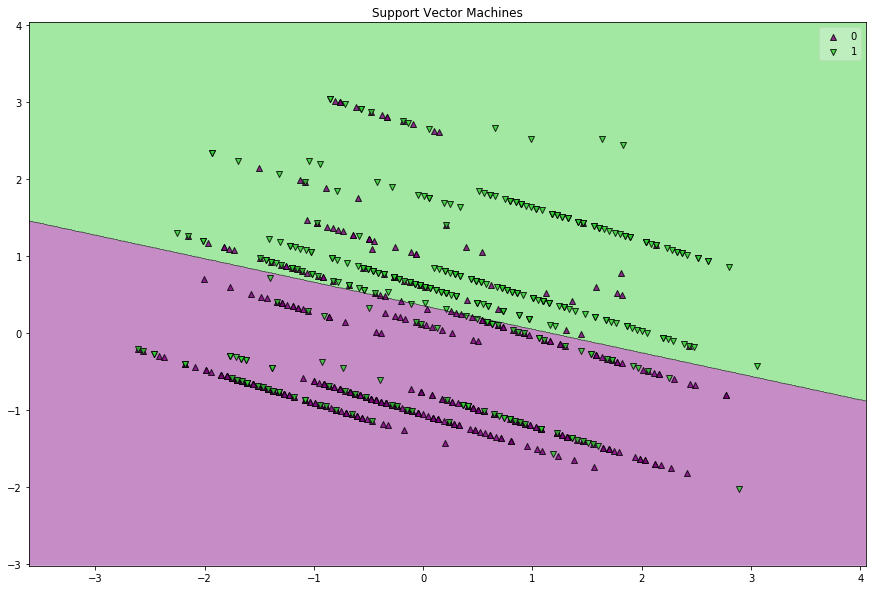

In [59]:
#visualization
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
X_train_reduced = PCA(n_components = 2).fit_transform(X_norm)
t = np.array(y)
t = t.astype(np.integer)
clf_svm = SVC(**best_params_svm)
clf_svm.fit(X_train_reduced,t)
plt.figure(figsize = [15,10])
plot_decision_regions(X_train_reduced, t, clf = clf_svm, hide_spines = False, colors = 'purple,limegreen',
                      markers = ['^','v'])
plt.title('Support Vector Machines')

In [69]:
score = cross_val_score(clf_svm, X_train_reduced,t, scoring = 'accuracy', cv = 10, n_jobs = -1).mean()
score

0.7758636931108841

In [62]:
print(best_params_svm)

{'C': 0.01, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [26]:
best_params_xg['gamma']='auto'

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


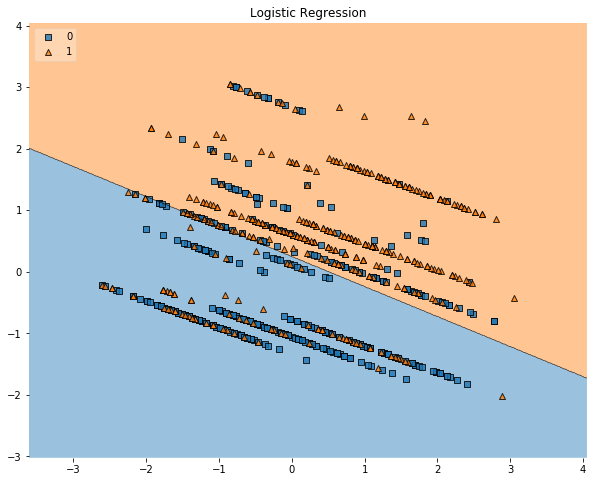

In [61]:
#mlxtend visualizations
import matplotlib.gridspec as gridspec
import itertools
# Plotting Decision Regions

#gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))
#ax = plt.subplot(gs[grd[0], grd[1]])
clf_lr.fit(X_train_reduced, y)
fig = plot_decision_regions(X=X_train_reduced, y=y,clf=clf_lr, legend=2)
plt.title("Logistic Regression")

plt.show()

In [79]:
#y_pred_lr = clf_lr.predict(X_test)
clf_svm.fit(npX,npy)
#y_pred_svm = linear_svc.predict(X_test)
y_pred_svm = clf_svm.predict(X_test)

In [80]:
(y_pred_svm==y_test).mean()

0.8

In [109]:
#naive bayes
clf_nbayes = GaussianNB()
clf_nbayes.fit(X,y)
y_pred_nbayes=clf_nbayes.predict(X_test)
(y_pred_nbayes==y_test).mean()

0.8

In [110]:
clf_nbayes = GaussianNB()
score = cross_val_score(clf_nbayes, X,y, scoring = 'accuracy', cv = 10, n_jobs = -1).mean()
score

0.7996260356372715